# Skin Cancer Detector with HAM10000

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sbn
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers



IMG_WIDTH = 64
IMG_HEIGHT = 64
labels=['Basal_Cell_Carcinoma',
        'Benign_Keratosis',
        'Bowens_disease',
        'Dermatofibroma',
        'Melanocytic_Nevi',
        'Melanoma',
        'Vascular_Lesions']

Let's define some utility functions that will come handy in the further analysis.

In [10]:
def print_two_confusion_matrix(cm_list, labels):
    fig, axes = plt.subplots(1,2, figsize=(13,5), subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=1, wspace=1))
    
    key = 0
    for axi, cm in zip(axes, cm_list):
        display = ConfusionMatrixDisplay(cm, display_labels=labels)
        plt.title= 'Naive' if key == 0 else 'Naive Augmented'
        key+=1
        display.plot(ax=axi, xticks_rotation=90)
        plt.ylabel='True Values'
        plt.xlabel='Predicted Values'
    
def print_confusion_matrix(cm, labels):
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    plt.title= 'Naive with balanced Dataset'
    # sbn.heatmap(cm, square=True, annot=True, cbar=False, fmt='g')
    display.plot(xticks_rotation = 90)
    plt.ylabel = 'True Values'
    plt.xlabel = 'Predicted Values'

def plot_accuracy_epochs(history):
    plt.plot(history['loss'])
    plt.title='Model loss/accuracy'
    plt.ylabe='Loss'
    plt.xlabel='Epoch'
    plt.legend(['Loss'], loc='upper left')

    plt2=plt.twinx()
    color = 'red'
    plt2.plot(history['accuracy'],color=color)
    plt.ylabel='Accuracy'
    plt2.legend(['Accuracy'], loc='upper center')

## Load the data and preprocessing
The dataset contains 10015 images divided in two parts. The 'HAM10000_metadata.csv' contains the ground truth of the dataset. Here we can use this file to retrieve the images from the relative folders and also analyse what the images are.

In [3]:
path = '.'
file_name = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(file_name, na_values=['NA','?'])
disease_types = pd.unique(df['dx'])
print(disease_types)

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


As you can see from the last print, there are 7 types of images classified in the dataset. Let's create a dictionary to better represent those diseases and then replace those with the full name of the skin patology.

In [4]:
images_type = {'bkl': 'Benign_Keratosis', 'nv': 'Melanocytic_Nevi',
                      'df': 'Dermatofibroma', 'mel': 'Melanoma',
                      'vasc': 'Vascular_Lesions', 'bcc': 'Basal_Cell_Carcinoma',
                      'akiec': "Bowens_disease"}
images_type
df.replace(images_type.keys(), images_type.values(), inplace=True)
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear


After having deleted the pieces of data that are not relevant for the analysis, we now check if there are any missing values.

In [5]:
df.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

From the analysis, it appears that the column of the 'age' has some missing values. To solve this problem we decided to fill those missing values with the median value.

In [6]:
median = df['age'].median()
df['age'] = df['age'].fillna(median)
df.isnull().any()
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Bowens_disease,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Bowens_disease,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Bowens_disease,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Bowens_disease,histo,80.0,male,face


After this brief pre-processing, we can see that there are 10015 images, each with a dimension of 600x450. We are going to reshape those images in a much scaled size 64x64 improve the performance in terms of speed of the model that we are going to build.

In [215]:
# Get the path of the original images directory
original_images_path = '/Users/tommasocapecchi/Datasets/HAM10000/Images/'
# Retrieve all the images path in the specified directory and store them into a list
images = [img for img in glob.glob(original_images_path+'*.jpg')]
# Create a new directory for the processed images
if not 'Processed_images' in os.listdir('/Users/tommasocapecchi/Datasets/HAM10000/'):
    os.mkdir('/Users/tommasocapecchi/Datasets/HAM10000/Processed_images')

# Iterate through all the images and names associated to open and resize those images. To open an image we are
# going to use the PIL library. Finally, save the new image in the previously created directory.
for img, name in zip(images, df['image_id']):
    data = Image.open(img)
    data = data.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
    data.save('/Users/tommasocapecchi/Datasets/HAM10000/Processed_images/'+name+'.jpg')

Now we update the dataframe, inserting a new column named 'image_path' that will specify for each image, the current path in the disk.

In [7]:
# Now it is useful to insert in the dataframe a column
# where for each image, locate the local path.
images_dir_path = '/Users/tommasocapecchi/Datasets/HAM10000/Processed_images/'
images_path = []
for image_name in df['image_id']:
    image_path = os.path.join(images_dir_path, image_name +'.jpg')
    images_path.append(image_path)

df['image_path'] = images_path
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Proce...


And finally we add another column called 'target', that will indeed contain the classification label for each image. As already shown, there are a total of 7 classes of skin cancer (values from 0 to 6)

In [8]:
# Identify the class of the skin cancer and encode them in a range of integers between [0-6].
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(df['dx']).reshape((-1,1))
df['target'] = labels
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,target
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1


Now we would like to count the numbers of skin cancers according to each category to see if the dataset is well balanced or not.

Now we are going to load the images and adapt them to the best of our possibilities with respect to the size. The images in the dataset comes with two directories, part-1 and part-2. We are going to retrieve those images in two different variables and then unify in one big piece of data.

Now let's build the set of the images with the corresponding labels.

## Building the model: training and evaluation phase

We are now going to build the actual Convolutional Neural Network to solve the problem of correctly classify the various type of skin cancer. To achieve this goal, first we are going to create a basic implementation to get initial results, then we are going to modify and apply different techniques to improve performances. 

Firstly, we are going to get the actual data from the images. Since each image is a 64x64 image represented in colors, each image will have a shape of (64,64,3) where the final dimension refers to the RGB channel. Each pixel will have a value between 0 and 255.

In [7]:
def build_data():
    X = []
    y = []
    # Iterate through the dataframe selecting the image path (to read the pixels value for each image)
    # and the target value and store those information.
    # into the 
    for path_img, label in zip(df['image_path'].values, df['target'].values):
        img = plt.imread(path_img, format='rgb')
        X.append(img)
        y.append(label)
    y = tf.keras.utils.to_categorical(y, num_classes=7)
    # Reshape the two list as numpy arrays. The X will have the shape (n_images, W, H, RGB)
    X = np.array(X, dtype=('float32')).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)

    #It is also a good practice to normalize the values of each pixel into a range between 0 and 1
    # to improve performances in the network.
    X = np.asarray([x/255 for x in X])
    return X, y

Now that the data is completely processed, we can split it into training and validation set using the sklearn library.

In [10]:
X, y = build_data()
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check splitting shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7511, 64, 64, 3)
(2504, 64, 64, 3)
(7511, 7)
(2504, 7)


Before building the model, let's print some of the images to verify that we scaled and shuffled properly the whole collection of the data.

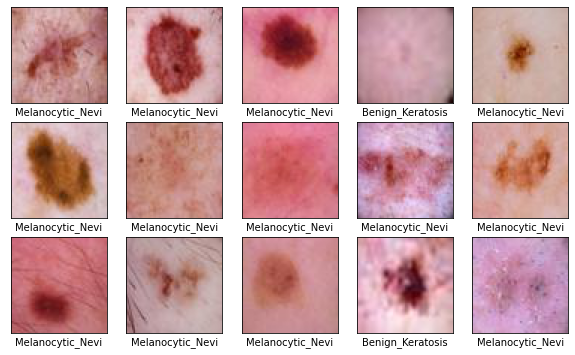

In [11]:
labels=['Basal_Cell_Carcinoma',
        'Benign_Keratosis',
        'Bowens_disease',
        'Dermatofibroma',
        'Melanocytic_Nevi',
        'Melanoma',
        'Vascular_Lesions']

fig, axes= plt.subplots(3,5, figsize=(10,6))
for i, axi in enumerate(axes.flat):
    axi.imshow(X_train[i])
    axi.set(xticks=[], yticks=[],
            xlabel=labels[np.argmax(y_train[i])])
    
plt.show()
plt.close()

Let's now build a naïve CNN to get some initial results and then let's try to adapt the CNN with a model that provides a higher performance.

In [12]:
def simple_CNN():
    model = Sequential()
    model.add(Conv2D(64,
                     kernel_size=(2, 2),
                     strides= 1,
                     padding='same',
                     input_shape=(64, 64, 3),
                     activation='relu'))
    model.add(Conv2D(32,
                     kernel_size=(2, 2),
                     strides= 1,
                     padding='same',
                     activation='relu')),
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    return model

In [282]:
model = simple_CNN()

custom_opt = opt.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 64)        832       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_24 (Dense)             (None, 7)                 903       
Total params: 16,267,111
Trainable params: 16,267,111
Non-trainable params: 0
__________________________________________

In [55]:
# Train the model
history = model.fit(X_train, y_train, batch_size=64, verbose=1, epochs=10)

Epoch 1/10
118/118 [==============================] - 68s 580ms/step - loss: 1.7979 - accuracy: 0.6514
Epoch 2/10
118/118 [==============================] - 74s 631ms/step - loss: 1.1451 - accuracy: 0.6707
Epoch 3/10
118/118 [==============================] - 71s 598ms/step - loss: 1.1447 - accuracy: 0.6706
Epoch 4/10
118/118 [==============================] - 67s 564ms/step - loss: 1.1342 - accuracy: 0.6707
Epoch 5/10
118/118 [==============================] - 65s 550ms/step - loss: 1.1303 - accuracy: 0.6709
Epoch 6/10
118/118 [==============================] - 66s 560ms/step - loss: 1.1194 - accuracy: 0.6715
Epoch 7/10
118/118 [==============================] - 66s 560ms/step - loss: 1.1174 - accuracy: 0.6727
Epoch 8/10
118/118 [==============================] - 66s 561ms/step - loss: 1.1057 - accuracy: 0.6731
Epoch 9/10
118/118 [==============================] - 65s 550ms/step - loss: 1.0926 - accuracy: 0.6745
Epoch 10/10
118/118 [==============================] - 66s 557ms/step - l

It is quite convenient to save the model so that we can retrieve the information later without having to train again the model to find the values for the weights. Let's also visualize the score and the confusion matrix regarding the performance of the model.

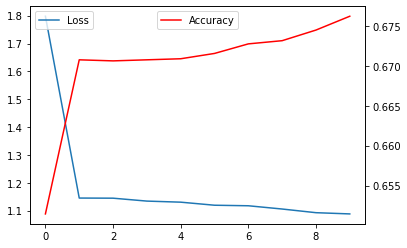

In [14]:
# # Save the training stats
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive'
# # UNCOMMENT TO SAVE THE HISTORY OF THE TRAINING MODEL
# with open(save_path, 'wb') as history_naive_file:
#     pickle.dump(history.history, history_naive_file)

# # UNCOMMENT TO SAVE THE MODEL
# model_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(model_path, 'naive_CNN.h5'))

# # Get the predictions from the test set and compute the accuracy from loaded actual model
# y_pred = model.predict(X_test)
# #now pick the most likely outcome
# y_pred = np.argmax(pred,axis=1)
# y_true = np.argmax(y_test,axis=1) 
# accuracy = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# plot_accuracy_epochs(history.history)

# UNCOMMENTO TO LOAD THE HISTORY
history = pickle.load(open('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive', 'rb'))

# UNCOMMENT TO LOAD THE MODEL
model = load_model(os.path.join('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/', 'naive_CNN.h5'))
# Get the predictions from the test set and compute the accuracy from loaded model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1) 
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
plot_accuracy_epochs(history)

From the printed results it appear that the model had initially a high value with respect to the loss that rapidly decreased, in fact the value dropped significantly in the first epoch while in the later ones it seems to have a constant dicreasing behaviour. In contrast, the accuracy of the model has an increasing behaviour even in the last epoch and this suggests that we should have let the model train longer. Furthermore, by visualizing the confusion matrix it appears that the model is faulty is several scenarios. Particularly we can see how the 0th, 1st and 5h category are often mistakenly classified as category 4.

## Enhancements: how to improve the system's performance

### Data Augmentation

One way to improve the system could be to generate more artificial data from the images that are already contained in the dataset. We can simply achieve this goal by using the class ImageDataGenerator of the keras library. In this case we will keep the same architecture for the neural network.

In [62]:
data_generator = ImageDataGenerator(rotation_range=10, 
                                    width_shift_range=0.2, 
                                    height_shift_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='nearest',
                                    rescale=None)
data_generator.fit(X_train)

model = Sequential()
model.add(Conv2D(64,
                 kernel_size=(2, 2),
                 strides= 1,
                 padding='same',
                 input_shape=X_train[0].shape,
                 activation='relu'))
model.add(Conv2D(32,
                 kernel_size=(2, 2),
                 strides= 1,
                 padding='same',
                 activation='relu')),
model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))

custom_opt = opt.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

# Train the model with augmentation applied
history = model.fit(data_generator.flow(X_train, y_train, batch_size=64), epochs=10)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 64)        832       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16257152  
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 7)                

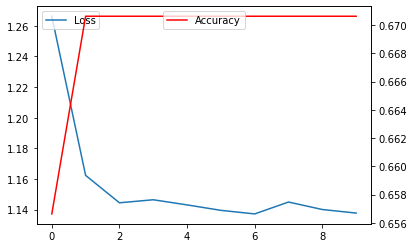

In [15]:
# # UNCOMMENT TO SAVE THE MODEL
# model_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(model_path , 'naive_augmented_CNN.h5'))

# # UNCOMMENT TO SAVE THE HISTORY OF THE MODEL
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive_aug'
# with open(save_path, 'wb') as hist_naive_aug:
#     pickle.dump(history.history, hist_naive_aug)
    
# # Get predictions from the loaded model
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# accuracy = accuracy_score(y_true, y_pred)
# plot_accuracy_epochs(history.history)

# UNCOMMENT TO LOAD THE MODEL
model = load_model(os.path.join('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/', 'naive_augmented_CNN.h5'))
# UNCOMMENT TO LOAD THE HISTORY
history = pickle.load(open('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive_aug', 'rb'))

# Get predictions from the loaded model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
plot_accuracy_epochs(history)

From the results, it appears that the model didn't improve its score, in fact we can observe a highly instable path of the accuracy score, probably related to the fact that the model doesn't have enough filters to capture all the features in the images. This proves that the model need to be reshaped with a differed (a more deep) architecture and, possibly, trained for longer epochs.

Below, we can also see how the two models are not different in terms of performances

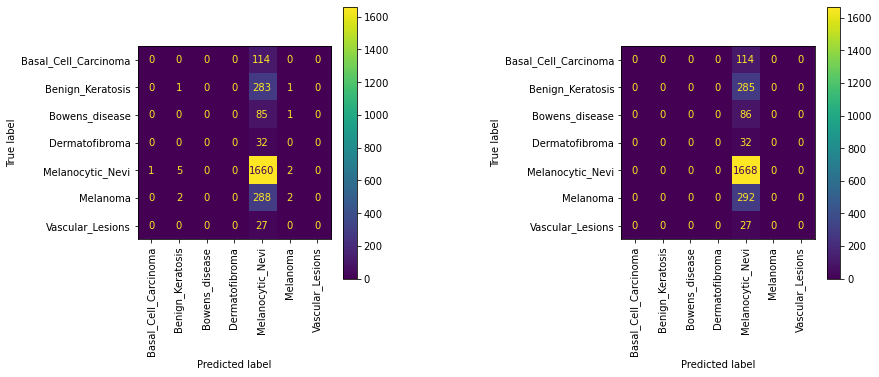

In [16]:
file_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'

naive_model = load_model(os.path.join(file_path, 'naive_CNN.h5'))
y_pred_naive = naive_model.predict(X_test)
y_pred_naive = np.argmax(y_pred_naive, axis=1)
y_true = np.argmax(y_test, axis=1)
cm_naive = confusion_matrix(y_true, y_pred_naive)

naive_aug_model = load_model(os.path.join(file_path, 'naive_augmented_CNN.h5'))
y_pred_naive_aug = naive_aug_model.predict(X_test)
y_pred_naive_aug = np.argmax(y_pred_naive_aug, axis=1)
y_true = np.argmax(y_test, axis=1)
cm_naive_aug = confusion_matrix(y_true, y_pred_naive_aug)

# Print confusion matrices
conf_matrices = [cm_naive, cm_naive_aug]
print_two_confusion_matrix(conf_matrices, labels=labels)

From the results, it appears that the CNN recognize each type of cancer as a 'Melanocytic_Nevi'. This problem is related to the fact that the categories in the dataset are highly imbalanced, thus during the training phase the model misclassify every other type of cancers because there are not enough images to build a sufficient general knowlegde.

To confirm this hypothesis we can see the following information:

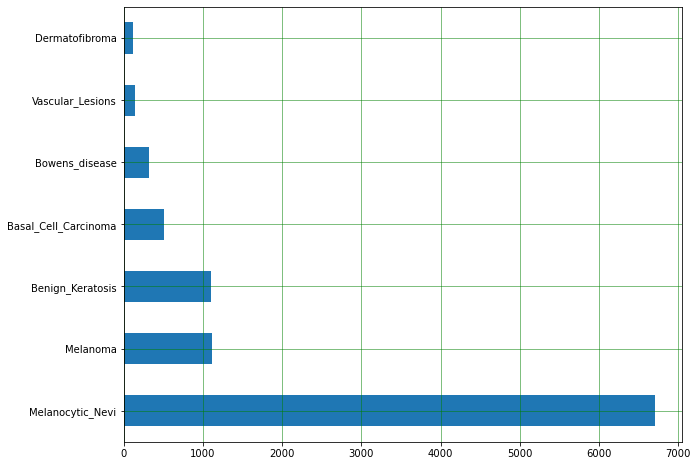

In [17]:
instances_cancer = df['dx'].value_counts()
instances_cancer

instances_cancer.plot(kind='barh', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

To deal with this problem we could try to implement an oversampling technique, generating more data (artificial images) based on the images that we already have, by only taking into account all the categories except for the 'Melanocytic_Nevi'. The goal is to reach approximately the same amount of images for all the categories. We can do that by using the data generator that keras provides.

In [274]:
# Create a new directory for the augmented images
if not 'Augmented_images' in os.listdir('/Users/tommasocapecchi/Datasets/HAM10000/'):
    os.mkdir('/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images')

def balance_dataset(df, data_gen):
    maximum_images_per_category = np.max(df['dx'].value_counts())
    n_image_to_create = 32
    save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images/'
    for cancer_type in pd.unique(df.dx):
        if cancer_type != 'Melanocytic_Nevi':
            while len(df.loc[df.dx == cancer_type]) < maximum_images_per_category:
                images_per_category = df.loc[df.dx == cancer_type]
                selected_image = images_per_category.sample()
                image_path = selected_image.image_path.values
                try:
                    if 'AUGMENTED' in image_path[0]:
                        continue
                    else:
                        image = plt.imread(image_path[0], format='rgb')
                except Exception as error:
                    print(f'error occured{error}')
                    continue
                image_created_counter = 0
                image = np.asarray(image).reshape((1,IMG_WIDTH, IMG_HEIGHT, 3))
                for batch in data_gen.flow(image, batch_size=1, save_to_dir=save_path,
                                                 save_prefix='AUGMENTED_'+selected_image.image_id.values[0],
                                                 save_format='jpg'):
                    
                    # take all the values in the columns of the already created
                    created_img = selected_image
                    
                    # create the new image id: it's created by the concatenation of the label 'AUGMENTED_'
                    # and the ID of the selected image
                    new_image_id = glob.glob(save_path+'AUGMENTED_'+created_img.image_id.values[0]+'*.jpg')

                    splitted_path = new_image_id[0].split('/')
                    img_id = splitted_path[-1]
                    img_id = img_id[0:-4]

                    created_img.image_id = img_id
                    
                    # Create the new path for the created image: it's the concatenation of the directory that
                    # stores all the images on disk and the new image id (previously created)
                    new_image_path = new_image_id[0]
                    created_img.image_path = new_image_path
                    df = df.append(created_img)
                    break
                print(len(df.loc[df.dx == cancer_type]))
    print(len(df.loc[df.dx == cancer_type]))
    return df

In [ ]:
data_generator = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.3,
                                    fill_mode='nearest',
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.4,0.9))
# The method balance_dataset artifically creates for each category (excluding Melanocytic levi) a series of images
# (generated by choosing randomly an already existing image in the dataset) such that the classes are well
# balanced
# THE EXECUTION OF THIS LINE WILL TAKE A LONG TIME!
# df = balance_dataset(df, data_generator)
# len(df)

In [18]:
# This piece of code can take few minutes to run but it's necessary to preoceed with the analysis
augmented_dir = '/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images/'
images = [img for img in glob.glob(augmented_dir+'*.jpg')]
print(len(df))
for path in images:
    image_id_splitted = path.split('/')[-1].split('_')
    last_id_part = image_id_splitted[-1].split('.')[0]
    image_id_original = str(image_id_splitted[1]+'_'+image_id_splitted[2])
    image_id_augmented = image_id_original+str('_'+image_id_splitted[3]+'_'+last_id_part)
    aug_image = df.loc[df.image_id == image_id_original]
    aug_image.image_id = str('AUGMENTED_'+image_id_augmented)
    aug_image.image_path = path
    aug_image.image_path.values
    df = df.append(aug_image)
print(len(df))

10015


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


46890


In [19]:
# for convenience the new dataframe is stored in csv file
df.to_csv('augmented_dataframe.csv')

By doing this, we are balancing the data to allow the model not only to recognise the 'Melanocitic_Nevi' but also the other types of images.

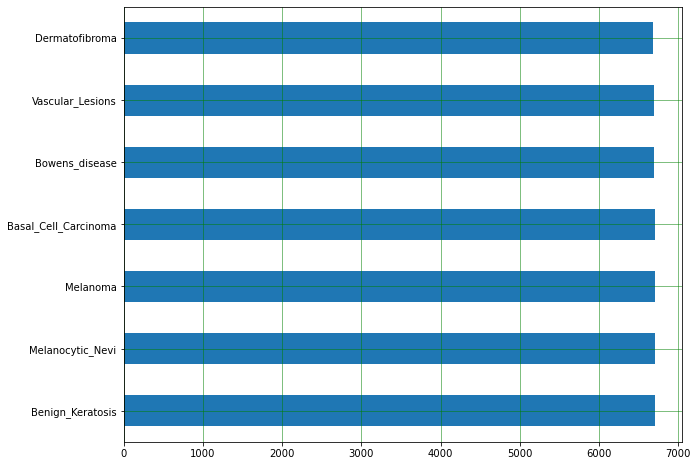

In [6]:
# Load csv file to create the new augmented dataframe
path = '.'
file_read = os.path.join(path, 'augmented_dataframe.csv')
df = pd.read_csv(file_read, na_values=['NA','?'])

instances_cancer = df['dx'].value_counts()
instances_cancer

instances_cancer.plot(kind='barh', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [8]:
# We are now going to reload our data to execute again the same CNN with the augmented data and a more well
# balanced dataset to see if the performances can improve.

X, y = build_data()
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check splitting shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35167, 64, 64, 3)
(11723, 64, 64, 3)
(35167, 7)
(11723, 7)


In [71]:
model = simple_CNN()
custom_opt = opt.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64, verbose=1, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 127008)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16257152  
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 903       
Total params: 16,267,111
Trainable params: 16,267,111
Non-trainable params: 0
____________________________________________

Accuracy: 0.4075748528533652


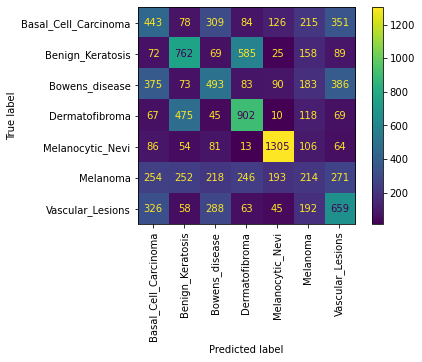

In [11]:
# # UNCOMMENT TO SAVE THE MODEL
# model_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(model_path , 'naive_balanced_dataset_CNN.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive_balanced_data'
# with open(save_path, 'wb') as hist_naive_balanced_file:
#     pickle.dump(history.history, hist_naive_balanced_file)
    
    
# # UNCOMMENT TO GET SCORE FROM CURRENT RUN MODEL
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# score = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# print_confusion_matrix(cm, labels)
    
# UNCOMMENT TO LOAD THE MODEL
model = load_model(os.path.join('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/',
                                'naive_balanced_dataset_CNN.h5'))
# UNCOMMENT TO LOAD THE HISTORY
history = pickle.load(open('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive_balanced_data', 'rb'))

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm, labels)
print(f'Accuracy: {score}')

From the results above, it appears that the model is overfitting the data, since in the training score the model has reached a 0.81 peak of accuracy, while in the evaluation score the model scored poorly (0.41). Thus, it's evident that to achieve higher scores, a new improved architectured is required. In the following section, we will discuss about these new improvements.

## More enhancements: data augmentation, more layers, regularization and early stop.

Now we are going to implement a series of improvement techniques to try to maximize the results from the CNN.
First of all, let's try with a different architecture for the CNN: we are going to both increase the number of filters in the CNN and neurons in the Dense layer. To avoid overfitting or useless waste of time in case that the CNN stops learning after a certain number of epochs, an early stopping criterion in also implemented. 

In [108]:
# data_generator = ImageDataGenerator(rotation_range=45,
#                                     width_shift_range=0.2,
#                                     height_shift_range=0.2,
#                                     zoom_range=0.2,
#                                     shear_range=0.1,
#                                     horizontal_flip=True,
#                                     vertical_flip=True,
#                                     fill_mode='nearest',
#                                     brightness_range=(0.4,0.9))
# data_generator.fit(X_train)

model = Sequential([
    
    tf.keras.layers.Conv2D(16,
                           kernel_size=(3,3),
                           input_shape=(64,64,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(32,
                           kernel_size=(3,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dense(64, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=2, verbose=1, mode='auto')
custom_opt = opt.Adam(beta_2=0.95)
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 63, 63, 64)        8256      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 63, 63, 64)        16448     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 246016)          

In [109]:
history = model.fit(X_train, y_train, batch_size=512, callbacks=[monitor], verbose=1, epochs=300)

# UNCOMMENT TO SAVE THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model.save(os.path.join(save_path, 'improved_final_CNN.h5'))

# UNCOMMENT TO SAVE THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
with open(save_history_improved, 'wb') as improved_hist_file:
    pickle.dump(history.history, improved_hist_file)

Epoch 1/300
69/69 [==============================] - 690s 10s/step - loss: 2.1058 - accuracy: 0.1717
Epoch 2/300
69/69 [==============================] - 667s 10s/step - loss: 1.8361 - accuracy: 0.2431
Epoch 3/300
69/69 [==============================] - 659s 10s/step - loss: 1.7098 - accuracy: 0.3043
Epoch 4/300
69/69 [==============================] - 662s 10s/step - loss: 1.5698 - accuracy: 0.3555
Epoch 5/300
69/69 [==============================] - 678s 10s/step - loss: 1.4510 - accuracy: 0.3991
Epoch 6/300
69/69 [==============================] - 692s 10s/step - loss: 1.3632 - accuracy: 0.4290
Epoch 7/300
69/69 [==============================] - 686s 10s/step - loss: 1.3053 - accuracy: 0.4496
Epoch 8/300
69/69 [==============================] - 692s 10s/step - loss: 1.2411 - accuracy: 0.4772
Epoch 9/300
69/69 [==============================] - 682s 10s/step - loss: 1.2100 - accuracy: 0.4912
Epoch 10/300
69/69 [==============================] - 656s 10s/step - loss: 1.1995 - accura

Score 0.44


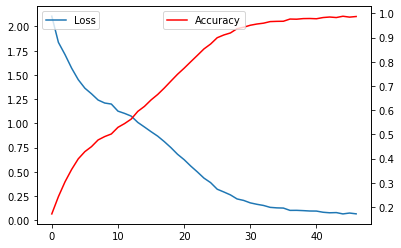

In [14]:
# # UNCOMMENT TO SAVE THE MODEL
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(save_path, 'improved_final_CNN.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
# with open(save_history_improved, 'wb') as improved_hist_file:
#     pickle.dump(history.history, improved_hist_file)

# UNCOMMENT TO LOAD THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model = load_model(os.path.join(save_path, 'improved_final_CNN.h5'))

# UNCOMMENT TO LOAD THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
history = pickle.load(open(save_history_improved, 'rb'))

# # FROM LOADED MODEL
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
print(f'Score {round(score, 2)}')
plot_accuracy_epochs(history)

# FROM NOT LOADED
# y_pred_improved = improved_model.predict(X_test)
# y_pred_improved = np.argmax(y_pred_improved, axis=1)
# improved_score = accuracy_score(y_test, y_pred_improved)
# plot_accuracy_epochs(history_improved_load)

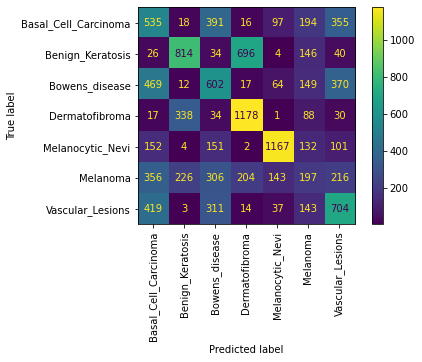

In [13]:
cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm, labels)

In [124]:
model = Sequential([
    tf.keras.layers.Conv2D(16,
                           kernel_size=(2,2),
                           input_shape=(64,64,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(32,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=2,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
custom_opt = opt.SGD()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)             

In [127]:
history = model.fit(X_train, y_train, batch_size=128, callbacks=[monitor], verbose=1, epochs=1000)

Epoch 1/1000
275/275 [==============================] - 210s 762ms/step - loss: 1.9389 - accuracy: 0.1666
Epoch 2/1000
275/275 [==============================] - 209s 760ms/step - loss: 1.9267 - accuracy: 0.1845
Epoch 3/1000
275/275 [==============================] - 207s 754ms/step - loss: 1.9096 - accuracy: 0.2014
Epoch 4/1000
275/275 [==============================] - 208s 756ms/step - loss: 1.8861 - accuracy: 0.2147
Epoch 5/1000
275/275 [==============================] - 207s 753ms/step - loss: 1.8633 - accuracy: 0.2275
Epoch 6/1000
275/275 [==============================] - 206s 750ms/step - loss: 1.8482 - accuracy: 0.2353
Epoch 7/1000
275/275 [==============================] - 210s 764ms/step - loss: 1.8307 - accuracy: 0.2459
Epoch 8/1000
275/275 [==============================] - 210s 764ms/step - loss: 1.8139 - accuracy: 0.2537
Epoch 9/1000
275/275 [==============================] - 203s 740ms/step - loss: 1.7990 - accuracy: 0.2616
Epoch 10/1000
275/275 [=======================

In [128]:
# # UNCOMMENT TO SAVE THE MODEL
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(save_path, 'improved_final_CNN_best.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history_best'
# with open(save_history_improved, 'wb') as improved_hist_file:
#     pickle.dump(history.history, improved_hist_file)

Score: 0.5368932867013563


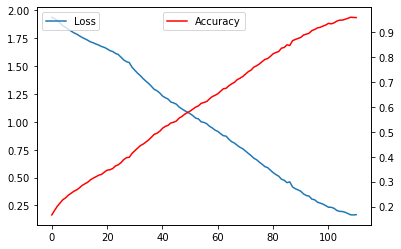

In [15]:
# UNCOMMENT TO LOAD THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model = load_model(os.path.join(save_path, 'improved_final_CNN_best.h5'))

# UNCOMMENT TO LOAD THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history_best'
history = pickle.load(open(save_history_improved, 'rb'))

# # FROM LOADED MODEL
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
plot_accuracy_epochs(history)
print(f'Score: {score}')

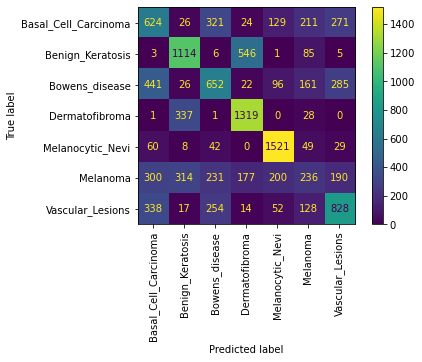

In [41]:
cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm, labels)

As a final observation it is worth plot other metrics with respect to the single category of cancers. This will allows us to understand which type of cancer the model has recognized the most and which none.

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

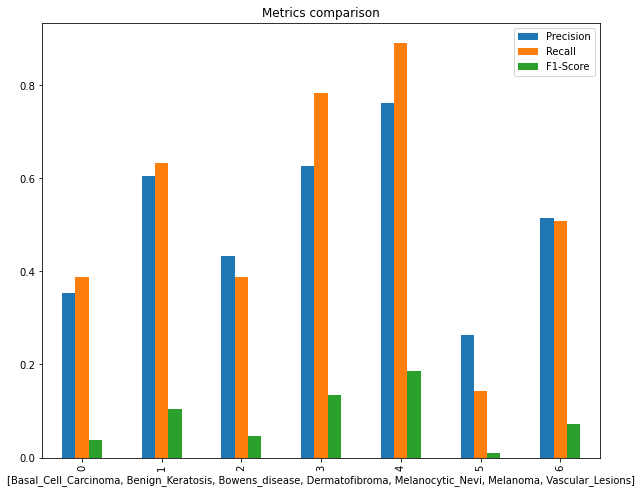

In [102]:
# get correct predictions (diagonal of the confusion matrix)
correct_per_category = [cm[i][i] for i,_ in enumerate(cm)]

# compute the precision: tp/tp+fp

# the denominator for the precision formula is just the sum of the values with respect to the columns
tp_fp = np.sum(cm, axis=0)
precision_scores = np.zeros((len(correct_per_category), 1))
for i, tp in enumerate(correct_per_category):
    precision_scores[i] = tp/(tp_fp[i])
# compute the recall: tp/tp+fn

# the denominator for the precision formula is just the sum of the values with respect to the rows
tp_fn = np.sum(cm, axis=1)
recall_scores = np.zeros((len(correct_per_category), 1))
for i, tp in enumerate(correct_per_category):
    recall_scores[i] = tp/(tp_fn[i])
    
# compute the f1 score: 2* P*R/(P+R)
f1_scores = 2*precision_scores*recall_scores/(np.sum(precision_scores)+np.sum(recall_scores))
scores = pd.DataFrame(np.c_[precision_scores, recall_scores, f1_scores],
                     columns=['Precision']+['Recall']+['F1-Score'])

# compute accuracy score: TP+TN/(TP+TN+FP+FN)

scores['label'] = labels
scores.plot(kind='bar', figsize=(10,8), xlabel=scores.label, title='Metrics comparison')